In [1]:
%matplotlib inline
import make_discrete_vdf as mdv
import numpy as np
import matplotlib.pyplot as plt
from fancy_plot import fancy_plot
from multiprocessing import Pool
import time
from scipy.optimize import curve_fit
import multi_fc_functions as mff
from scipy.interpolate import RectBivariateSpline


In [2]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [3]:
#set up plasma parameters
#                    Vx  ,  Vy,  Vz ,Wper,Wpar, Np
#pls_par = np.array([-380., -30., 30., 20., 40., 5.]) 
pls_par = np.array([-580., 10., -10., 20., 20., 15.]) 
#pls_par = np.array([-480., -100., -80., 20., 50., 25.])
#pls_par = np.array([-380., -100., 50., 30., 10., 50.]) 
#pls_par = np.array([-880., 100.,-150., 30., 10., 5.]) 
#mag_par = np.array([np.cos(np.radians(75.))*np.cos(.1), np.sin(np.radians(75.))*np.cos(.1), np.sin(.1)]) 
#mag_par = np.array([-np.cos(np.radians(25.)),np.sin(np.radians(25.)), 0.]) 
mag_par = np.array([-1.,0., 0.])

#Set up observering condidtions before making any VDFs
#veloity grid
#########################################
######################################
#grid_v = np.arange(450,790,20)
v_mag = np.sqrt(np.sum(pls_par**2))
grid_v = np.arange(v_mag-250,v_mag+250,20)
#get effective area of wind and other coversion parameters
waeff = 3.8e6 #cm^3/km
q0    = 1.6021892e-7 # picocoulombs
dv    = np.diff(grid_v)
dv    = np.concatenate([dv,[dv[-1]]])
cont  = 1.e12/(waeff*q0*dv*grid_v)

In [4]:
#Changed to mean km/s in p,q space 2018/10/19
samp = 1.5e1
#make a discrete VDF
#updated clip to a velocity width 2018/10/12 J. Prchlik
#Set to a "Total velocity width" which could be measured by the space craft 2018/10/15
vel_clip = 8.*np.sqrt(np.sum(pls_par[4:6]**2))
dis_vdf = mdv.make_discrete_vdf(pls_par,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
normval = np.ones(dis_vdf['pgrid'].shape)
normval /= np.sum(normval)

#Add a positive Gaussian Kernal to "Measured" VDF
dis_vdf['vdf'] += dis_vdf['vdf'].max()*np.exp(- ((dis_vdf['pgrid']-(-100))/10)**2. - ((dis_vdf['qgrid']-(0))/5)**2.)
#update the interpolator function
dis_vdf['vdf_func'] =  RectBivariateSpline(dis_vdf['pgrid'][:,0],dis_vdf['qgrid'][0,:],dis_vdf['vdf'])
                         

#get random angles of faraday cup in phi and theta
#number of fc cups
ncup = 20
#set random seed for FC angles
#np.random.seed(1107)


#Get two uniform number between -30 and 30
limit = 90.
phis = np.random.uniform(-limit,limit,size=ncup)
thetas = np.random.uniform(-30.,30.,size=ncup)


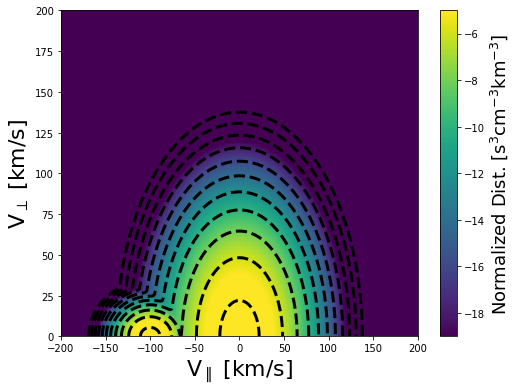

In [5]:
#"REAL" OBSERVATION
mdv.plot_vdf(dis_vdf)
plt.show()

In [6]:

#array that store all the fit parameters 
big_arr = []
#calculate the "real measured reduced response function" for all fc cups
fcs = {}
for k,(phi,theta) in enumerate(zip(phis,thetas)):
    #calculate x_meas array
    x_meas = mdv.make_fc_meas(dis_vdf,fc_spd=grid_v,fc_phi=phi,fc_theta=theta)
    #compute the observed current in the instrument
    #Use dynamic sampling 2018/10/12 J. Prchlik
    #rea_cur = mdv.arb_p_response(x_meas,dis_vdf,samp)
    rad_phi,rad_theta = np.radians((phi,theta))
    pro_unt = np.array([np.cos(rad_phi)*np.cos(rad_theta),np.sin(rad_phi)*np.cos(rad_theta),np.sin(rad_theta)])
    peak = np.abs(pls_par[:3].dot(pro_unt))
    #here sampling is in km/s
    rea_cur = mdv.arb_p_response(x_meas,dis_vdf,samp)
    #switched back to static sampling but now using p',q',r' for sampling
    #rea_cur = mdv.arb_p_response_dyn_samp(x_meas,dis_vdf,peak)

    #create key for input fc
    key = 'fc_{0:1d}'.format(k)
    fcs[key] = {}

    #populate key with measurements and parameter 
    fcs[key]['x_meas']  = x_meas
    fcs[key]['rea_cur'] = rea_cur
    fcs[key]['peak']    = peak


    #calculate the Gaussian fit of the response
    try:
        popt, pcov = curve_fit(gaus,grid_v,rea_cur*cont,p0=[np.nanmax(rea_cur*cont),np.mean(grid_v),np.sqrt(2.)*2*dv[0]],sigma=1./(rea_cur/rea_cur.min()),maxfev=5000)
    except RuntimeError:
        #give number that will be thrown out if no fit is found 
        popt = np.zeros(3)-9999.9
        pcov = np.zeros((3,3))-9999.9


    #Switched to computing the average
    #####get the parameters from the fit
    u = popt[1] #speed in km/s
    w = np.abs(popt[2]*np.sqrt(2.)) #thermal speed in km/s
    n = popt[0]*w*np.sqrt(np.pi) #density in cc
    ####
    #####uncertainty in parameters from fit
    du = np.sqrt(pcov[1,1])
    dw = np.sqrt(pcov[2,2])
    dn = np.sqrt(np.pi*((w**2.*pcov[0,0]) + (dw*n)**2))


    #Add fit parameters with velocity guesses
    big_arr.append([u,w,n,phi,theta,du,dw,dn])


#convert big_arr intop numpy array
big_arr = np.array(big_arr)

/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in sqrt
/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in sqrt


In [7]:
#get speed solution per observatory
v_angl = big_arr[:,0]
uv_angl = big_arr[:,5]
#thermal speed in GSE
w_angl = big_arr[:,1]
uw_angl = big_arr[:,6]
#get the density to compute the magnitude
n_angl = big_arr[:,2]
un_angl = big_arr[:,7]



#Number of processors to use when parallel processing
nproc = 8




In [8]:
#Use the top 5 peaks to get density and velocity values if the number of measurements are greater than 5
top5 = n_angl > np.sort(n_angl)[-6]

#get v_gse solution (Produces the same solution as the Wind spacecraft solution)
#in /crater/observatories/wind/code/dvapbimax/sub_bimax_moments.pro
v_vec =  mdv.compute_gse_from_fit(np.radians(phis[top5]),np.radians(thetas[top5]),-v_angl[top5]) #np.dot(np.dot(np.dot(v_svdc.T,wp_svdc),u_svdc.T),v_angl)
vx,vy,vz = v_vec


In [9]:
#Get Wper and Wpar vectors using SVD and the magnetic field vectors
wv_par =  mdv.compute_gse_from_fit(np.radians(phis[top5]),np.radians(thetas[top5]),w_angl[top5])
wa = np.abs(wv_par.dot(mag_par))
we = np.sqrt(np.linalg.norm(wv_par)**2.-wv_par.dot(mag_par)**2.)



In [10]:
#compute angle between FC and the observed bulk velocity (cos(theta`))
n = np.median(np.abs(n_angl[top5]))

In [11]:
#dont let initial guess be smaller than half a bin size
if we < min(dv)/2.:
    we = min(dv)/2.


#make a discrete VDF with the incorrect parameters but the same grid
pls_par_bad = np.array([vx, vy, vz,we,wa,n])




In [12]:

######################################################################
######################################################################
#EVERYTHING BEFORE THIS WOULD BE MEASURED BY A SPACECRAFT
######################################################################
######################################################################

#Updated with vel_clip parameter 2108/10/12 J. Prchlik
dis_vdf_bad = mdv.make_discrete_vdf(pls_par_bad,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
#store the initial bad guess 
dis_vdf_bad_guess = dis_vdf_bad

In [13]:
#Get the initial distribution based on input parameters 2018/09/19 J. Prchlik 
for k,i in enumerate(fcs.keys()):
    i = 'fc_{0:1d}'.format(k)
    #updated using dynamic sampling 2018/10/12 J. Prchlik
    fcs[i]['init_guess'] = mdv.arb_p_response(fcs[i]['x_meas'],dis_vdf_bad_guess,samp)






In [14]:
#######Give info on best fit versus real solution######
print(pls_par)
print(pls_par_bad)

[-580.   10.  -10.   20.   20.   15.]
[-580.02912701   10.2420547    -9.63364363   10.           22.47390873
   13.21904882]


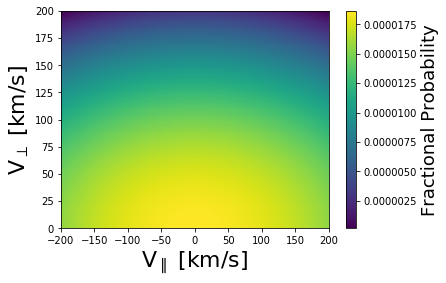

In [15]:
#create grid to call predictions
#pred_grid = np.zeros(dis_vdf_bad_guess['pgrid'].shape)+1
#change initial prediction to be based on the log of the input VDF
pred_grid = np.log10(dis_vdf_bad_guess['vdf'])
pred_grid -= np.min(pred_grid)
pred_grid /= np.sum(pred_grid)

#default prediction grid to set back to if the function gets stuck
default_grid = pred_grid

fig, ax = plt.subplots()

plotc = ax.pcolormesh(dis_vdf_bad_guess['pgrid'],dis_vdf_bad_guess['qgrid'],pred_grid)
cbar = fig.colorbar(plotc)

cbar.set_label('Fractional Probability',fontsize=18)
ax.set_xlabel(r'V$_\parallel$ [km/s]',fontsize=22)
ax.set_ylabel(r'V$_\perp$ [km/s]',fontsize=22)
plt.show()


In [16]:
#Grid sampling the edge of the velocity width first
pred_grid =  np.exp(-(((dis_vdf_bad_guess['pgrid']-wa))**2. + ((dis_vdf_bad_guess['qgrid']-we))**2.)/40**2)
pred_grid /= np.sum(pred_grid)

In [17]:
#Probability of selecting a gaussian that subtracts or adds to the vdf
n_p_prob = np.array([0.5,0.5])

#Inital bad sum squared error value
tot_err = 1e31 #a very large number
per_err = .10

#whether a given p, q value improved the fit
improved = False
ip,iq = 0.,0.

In [28]:
#counter tells the number of iterations to go before resetting the initial guess PDF
counter = 0
#Number of iterations before resetting
tol_cnt = 100


#kernel size for fitting
kernel = 30/np.sqrt(2.)

start_loop = time.time()
#removed to test improving fit
for i in range(300):
    #error from previous iteration
    pre_err = per_err
    #get a new vdf and return if it is the best fit
    #dis_vdf_bad,tot_error,dis_cur = create_random_vdf(dis_vdf_bad,nproc,n_p_prob)
    #print(ip,iq,n_p_prob)
    fcs,tot_err,dis_vdf_bad,improved,ip,iq,n_p_prob = mff.create_random_vdf_multi_fc(fcs,nproc,tot_err,
                                                                            dis_vdf_bad,cont,pred_grid,
                                                                            kernel,
                                                                            improved=improved,ip=ip,
                                                                            iq=iq,n_p_prob=n_p_prob,
                                                                            sc_range=per_err,samp=samp)
    
    if improved:
        #scale probability by how large of a jump is made
        if tot_err > 1e30:
            scale = 0.1
        else:
            scale = (pre_err-tot_err)
            if scale < 0.:
                scale = 0.
        
        #calculate peak at ip,iq values
        a = 1000.*(scale)/float(pred_grid.size)
        #create new probability grid with a Gaussian Kernal Added at the new point
        pred_grid += a*np.exp(- ((dis_vdf_bad_guess['pgrid']-ip)/(100.*per_err))**2./2.
                              - ((dis_vdf_bad_guess['qgrid']-iq)/(100.*per_err))**2./2.)
        #normalize to 1
        pred_grid /= np.sum(pred_grid)
        
        #Remove 10 guesses for counter for bad guesses
        counter -= 10
        #Do not let counter go below 0
        if counter < 0:
            counter = 0
    else:
        #increment the bad guess for the current model pdf
        counter += 1
        #reset the grid back to the default if there are too many bad guess with current pdf
        if counter > tol_cnt:
            pred_grid = default_grid
            #decrease the kernel size by 10%
            kernel *= 0.9
        print('Current Kerel Size',round(kernel*np.sqrt(2.)))
    print(counter)
        
         
    per_err = tot_err

    print('Total error for iteration {0:1d} is {1:4.3e}%'.format(i,100.*float(tot_err)))

end_loop = time.time()
print('Loop time {0:1.1f}'.format(end_loop-start_loop))

('Current Kerel Size', 30.0)
1
Total error for iteration 0 is 1.411e+01%
('Current Kerel Size', 30.0)
2
Total error for iteration 1 is 1.411e+01%
('Current Kerel Size', 30.0)
3
Total error for iteration 2 is 1.411e+01%
('Current Kerel Size', 30.0)
4
Total error for iteration 3 is 1.411e+01%
('Current Kerel Size', 30.0)
5
Total error for iteration 4 is 1.411e+01%
('Current Kerel Size', 30.0)
6
Total error for iteration 5 is 1.411e+01%
('Current Kerel Size', 30.0)
7
Total error for iteration 6 is 1.411e+01%
('Current Kerel Size', 30.0)
8
Total error for iteration 7 is 1.411e+01%
('Current Kerel Size', 30.0)
9
Total error for iteration 8 is 1.411e+01%
('Current Kerel Size', 30.0)
10
Total error for iteration 9 is 1.411e+01%
('Current Kerel Size', 30.0)
11
Total error for iteration 10 is 1.411e+01%
('Current Kerel Size', 30.0)
12
Total error for iteration 11 is 1.411e+01%
('Current Kerel Size', 30.0)
13
Total error for iteration 12 is 1.411e+01%
('Current Kerel Size', 30.0)
14
Total error 

('Current Kerel Size', 30.0)
68
Total error for iteration 111 is 1.091e+01%
('Current Kerel Size', 30.0)
69
Total error for iteration 112 is 1.091e+01%
('Current Kerel Size', 30.0)
70
Total error for iteration 113 is 1.091e+01%
('Current Kerel Size', 30.0)
71
Total error for iteration 114 is 1.091e+01%
('Current Kerel Size', 30.0)
72
Total error for iteration 115 is 1.091e+01%
('Current Kerel Size', 30.0)
73
Total error for iteration 116 is 1.091e+01%
63
Total error for iteration 117 is 1.091e+01%
53
Total error for iteration 118 is 1.090e+01%
('Current Kerel Size', 30.0)
54
Total error for iteration 119 is 1.090e+01%
('Current Kerel Size', 30.0)
55
Total error for iteration 120 is 1.090e+01%
('Current Kerel Size', 30.0)
56
Total error for iteration 121 is 1.090e+01%
('Current Kerel Size', 30.0)
57
Total error for iteration 122 is 1.090e+01%
('Current Kerel Size', 30.0)
58
Total error for iteration 123 is 1.090e+01%
48
Total error for iteration 124 is 1.089e+01%
38
Total error for iter

('Current Kerel Size', 30.0)
12
Total error for iteration 235 is 5.798e+00%
2
Total error for iteration 236 is 5.796e+00%
0
Total error for iteration 237 is 5.794e+00%
0
Total error for iteration 238 is 5.793e+00%
0
Total error for iteration 239 is 5.792e+00%
('Current Kerel Size', 30.0)
1
Total error for iteration 240 is 5.792e+00%
('Current Kerel Size', 30.0)
2
Total error for iteration 241 is 5.792e+00%
('Current Kerel Size', 30.0)
3
Total error for iteration 242 is 5.792e+00%
('Current Kerel Size', 30.0)
4
Total error for iteration 243 is 5.792e+00%
('Current Kerel Size', 30.0)
5
Total error for iteration 244 is 5.792e+00%
('Current Kerel Size', 30.0)
6
Total error for iteration 245 is 5.792e+00%
('Current Kerel Size', 30.0)
7
Total error for iteration 246 is 5.792e+00%
('Current Kerel Size', 30.0)
8
Total error for iteration 247 is 5.792e+00%
('Current Kerel Size', 30.0)
9
Total error for iteration 248 is 5.792e+00%
('Current Kerel Size', 30.0)
10
Total error for iteration 249 is 

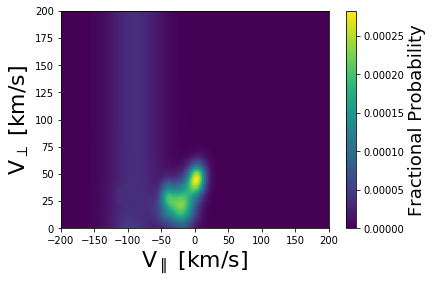

In [29]:
#Show prediction grid 
fig, ax = plt.subplots()

plotc = ax.pcolormesh(dis_vdf_bad_guess['pgrid'],dis_vdf_bad_guess['qgrid'],pred_grid)
cbar = fig.colorbar(plotc)

cbar.set_label('Fractional Probability',fontsize=18)
ax.set_xlabel(r'V$_\parallel$ [km/s]',fontsize=22)
ax.set_ylabel(r'V$_\perp$ [km/s]',fontsize=22)
plt.show()

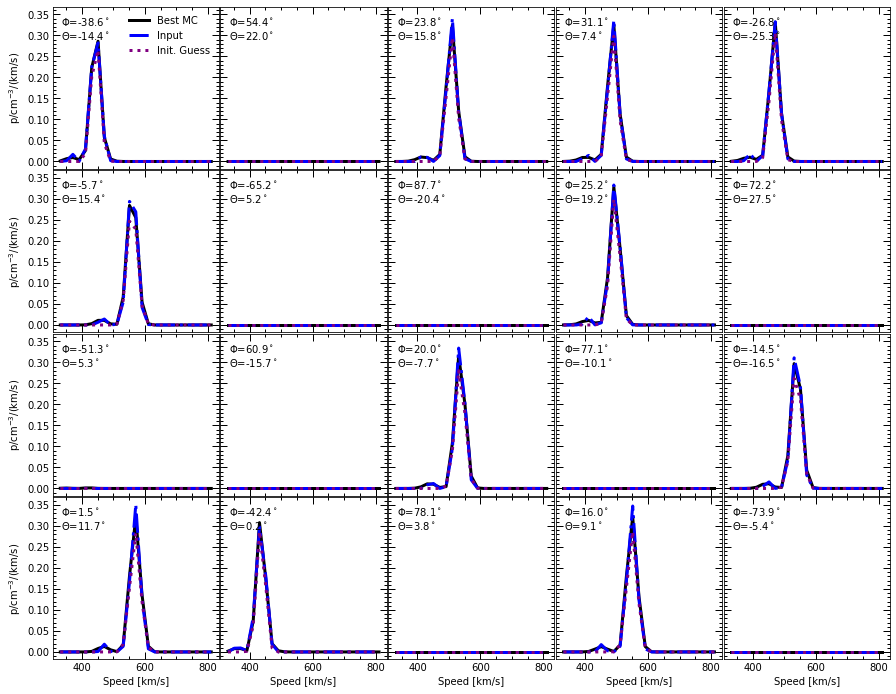

In [30]:
#Grid of FC guesses
mff.create_fc_grid_plot(fcs)
plt.show()

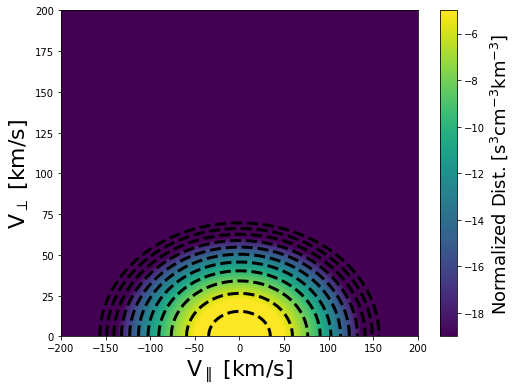

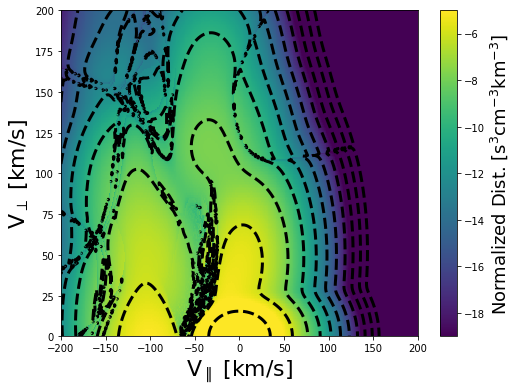

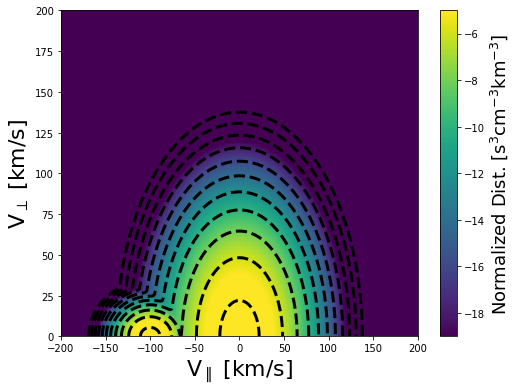

In [31]:
#Initial Guess from measurements
mdv.plot_vdf(dis_vdf_bad_guess)

#Best Fit MC VDF
mdv.plot_vdf(dis_vdf_bad)

#"REAL" OBSERVATION
mdv.plot_vdf(dis_vdf)

plt.show()

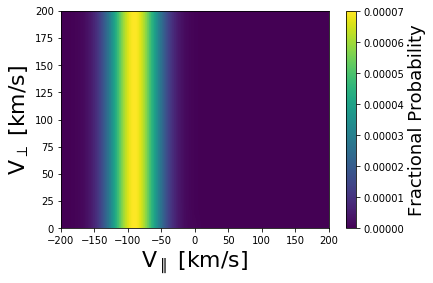

In [23]:
#Update the predction grid to drive a Gaussian at ~-100 with a width of 20 km/s based on the bump 100 km/s prior
#change initial prediction to be based on the log of the input VDF
pred_grid = np.exp(- ((np.sqrt(dis_vdf['pgrid']**2+dis_vdf['qgrid']**2)-(-90))/40)**2.)
pred_grid += np.exp(- ((dis_vdf['pgrid']-(-90))/40)**2.)
pred_grid /= np.sum(pred_grid)
#default prediction grid to set back to if the function gets stuck
default_grid = pred_grid

fig, ax = plt.subplots()

plotc = ax.pcolormesh(dis_vdf_bad_guess['pgrid'],dis_vdf_bad_guess['qgrid'],pred_grid)
cbar = fig.colorbar(plotc)

cbar.set_label('Fractional Probability',fontsize=18)
ax.set_xlabel(r'V$_\parallel$ [km/s]',fontsize=22)
ax.set_ylabel(r'V$_\perp$ [km/s]',fontsize=22)
plt.show()

In [144]:
#robost length
def robost_length(x0,x1):
    if x0 > x1:
        dist = x0*np.sqrt(1.+(x1/x0)**2)
    else:
        dist = x1*np.sqrt(1.+(x0/x1)**2)
    return dist

#compute root 
def get_root(r0,z0,z1,g,max_iterations=100):
    n0 = r0*z0
    s0 = z1-1
    s1 = robost_length(n0,z1)
    s = 0.
    i = 0   

    while i < max_iterations:
        s = (s0+s1)/2.
        if ((s == s0) | (s == s1)):
            return s
        ratio0, ratio1 = n0/(s+r0), z1/(s+1)
        g = (ratio0)**2+(ratio1)**2-1
        if (g > 0.):
            s0 = s
        elif (g < 0.): 
            s1 = s
        else:
            return s
        i += 1
        
    return 1.e30
        

#compute distance from ellipse 
#https://www.geometrictools.com/Documentation/DistancePointEllipseEllipsoid.pdf Section 2.7
def distance_point_ellipse(a,b,x,y):
    if y > 0:
        if x > 0:
            #initial guess for root finding
            z0 = x/a
            z1 = y/b
            g = (z0)**2+(z1)**2-1
            if (g != 0):
                r0 = np.sqrt(a/b)
                sbar = get_root(r0,z0,z1,g)
                x0 = r0*x/(sbar+r0)
                y0 = y/(sbar+1)
                #print(sbar)
                dist = np.sqrt((x-x0)**2+(y-y0)**2)
                print(x0,y0)
            else:
                x0,y0,dist = x,y,0
        else: 
            x0 = 0
            y0 = b
            dist = np.abs(y-y0)
    else:
        numer0 = a*x
        denom0 = np.sqrt(a)-np.sqrt(b)
        if numer0 < denom0:
            xde0 = numer0/denom0
            x0 = a*xde0
            y0 = b*np.sqrt(1-(xde0)**2)
            dist = np.sqrt((x0-x)**2+y0**2)
        else:
            x0 = a
            y0 = 0
            dist = np.abs(x-x0)
    return dist

def ellipse_distance_pq(a,b,pgrid,qgrid):
    #array of x and y values
    xs,ys = pgrid.ravel(),qgrid.ravel()
    #array of distances
    ds = np.zeros(xs.size)-9999.
    
    #compute the distances to each point from an ellipse
    for i,(x,y) in enumerate(zip(xs,ys)):
        ds[i] = distance_point_ellipse(a,b,x,y)
    
    ds = ds.reshape(pgrid.shape)
    return ds

In [145]:
dis,x0,y0 = distance_point_ellipse(wa,we,22.49,0.01)
print(wa,we,dis,(x0/wa)**2+(y0/we)**2)

(22.473897520231066, 0.0099892703035056127)
(22.473908733087345, 10.0, 0.01610248334373483, 1.0)


In [154]:
import geo_dist as gd
reload(gd)

<module 'geo_dist' from 'geo_dist.so'>

In [156]:
dist = gd.ellipse_distance_pq(wa,we,np.abs(dis_vdf['pgrid'].ravel().tolist()),dis_vdf['qgrid'].ravel().tolist())

TypeError: 'list' does not have the buffer interface

In [129]:
dis = distance_point_ellipse(wa,we,.02,0.01)
print(wa,we,dis)

(22.473908733087345, 10.0, 8.9839126447992346)


268.245120798
0.0
(401, 201)


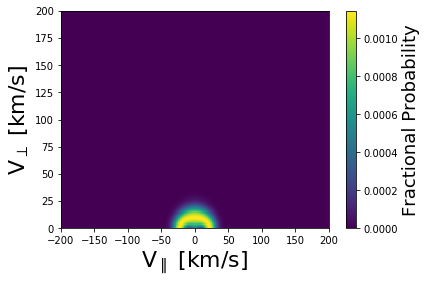

In [147]:
#Update the predction grid to drive a Gaussian at ~-100 with a width of 20 km/s based on the bump 100 km/s prior
print(np.max(dist))
print(np.min(dist))
#change initial prediction to be based on the log of the input VDF
pred_grid = np.exp(- (dist/10)**2.)
pred_grid /= np.sum(pred_grid)
#default prediction grid to set back to if the function gets stuck
default_grid = pred_grid

print(pred_grid.shape)

fig, ax = plt.subplots()

plotc = ax.pcolormesh(dis_vdf_bad_guess['pgrid'],dis_vdf_bad_guess['qgrid'],pred_grid)
cbar = fig.colorbar(plotc)

cbar.set_label('Fractional Probability',fontsize=18)
ax.set_xlabel(r'V$_\parallel$ [km/s]',fontsize=22)
ax.set_ylabel(r'V$_\perp$ [km/s]',fontsize=22)
plt.show()